#### IMPORT

In [1]:
import os, platform

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot


from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc


from sklearn.metrics import roc_curve, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [2]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 194 #291 #194 #37 #98 #190 #61 #37 #46
# N_CLASSES= 9
TIMESTEPS = 1
EPOCH=10
BATCH_SIZE=500

###############
# # dataset # #
###############
DATASET_DIR_NAME = "dataset"
# SAMPLE_DATASET_NAME = "rand97_train" + ".csv"
# ACTUAL_DATASET_NAME = "rand97_test" + ".csv"
SAMPLE_DATASET_NAME = "flm2m_rand194_train" + ".csv"
ACTUAL_DATASET_NAME = "flm2m_rand194_test" + ".csv"
# SAMPLE_DATASET_NAME = "flm2m_rand291_train" + ".csv"
# ACTUAL_DATASET_NAME = "flm2m_rand291_test" + ".csv"

MODEL_DIR_NAME = "model"
MODEL_NAME = "flm2m_rand194_model" + ".h5"
RESULT_NAME = "results_flm2m_rand194" + ".csv"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME)
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME)

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME)

CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2 #6 #4
# CLASS_LIST = ['adhy', 'alan', 'andy', 'bryce', 'chris', 'cy', 'gerald', 'jc', 'jonah', 'qk']
CLASS_LIST = ['adhy', 'andy', 'bryce', 'chris', 'cy', 'hr', 'jc', 'ys']
# CLASS_LIST = ['andy', 'azfar', 'gerald', 'jonah', 'ys']

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

def df_drop(df):
#     df.drop(df[df['Subject']=='adhy'].index, inplace=True)
    df.drop(df[df['Subject']=='alan'].index, inplace=True)
    df.drop(df[df['Subject']=='andy'].index, inplace=True)
    df.drop(df[df['Subject']=='bryce'].index, inplace=True)
    df.drop(df[df['Subject']=='chris'].index, inplace=True)
#     df.drop(df[df['Subject']=='cy'].index, inplace=True)
    df.drop(df[df['Subject']=='gerald'].index, inplace=True)
    df.drop(df[df['Subject']=='jc'].index, inplace=True)
    df.drop(df[df['Subject']=='jonah'].index, inplace=True)
#     df.drop(df[df['Subject']=='qk'].index, inplace=True)
    
    return df

In [3]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
    pass
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")

Dataset directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\dataset
Model directory exists at: C:\Users\spencer\Documents\Github\deep-captcha\model


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [4]:
# create base model
def create_base_model():
    model = Sequential()
#     model.add(LSTM(units=128, return_sequences=True, 
#                  input_shape=(TIMESTEPS,N_FEATURES)))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
    model.add(LSTM(units=1024, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=512, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=128, return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=128, return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=128, return_sequences=True))
#     model.add(BatchNormalization())
#     model.add(LSTM(units=64, return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    # softmax for multi-class classification
    model.add(Flatten())
    print(n_classes)
    model.add(Dense(n_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model



In [5]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)


    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb

In [6]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    # retrieve number of classes
    n_classes = y_train.shape[1]

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    print(f"Number of Classes: {n_classes}")

    return X_train, X_test, y_train, y_test, n_classes

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X


#### CHECK DATASET

In [7]:
#     sns.catplot(x="Subject", y="D|0", data=df)

    
#     sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|3", hue="D|3", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|4", hue="D|4", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|5", hue="D|5", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|6", hue="D|6", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|7", hue="D|7", data=df, legend=False)
#     sns.catplot(x="Subject", y="D|8", hue="D|8", data=df, legend=False)
# df = pd.read_csv(SAMPLE_DATASET_PATH)
# df.head()
# sns.catplot(x="Subject", y="D|1", hue="D|1", data=df, legend=False)
# sns.catplot(x="Subject", y="I|1+2", hue="I|1+2", data=df, legend=False)
# sns.catplot(x="Subject", y="PF|1+2", hue="PF|1+2", data=df, legend=False)
# sns.catplot(x="Subject", y="RF|1+2", hue="RF|1+2", data=df, legend=False)
# sns.catplot(x="Subject", y="DT|1+2", hue="DT|1+2", data=df, legend=False)
# sns.catplot(x="Subject", y="D|9", hue="D|9", data=df, legend=False)


#     sns.catplot(x="Subject", y="TT|1+3", hue="TT|1+3", data=df, legend=False)
#     sns.catplot(x="Subject", y="QT|1+4", hue="QT|1+4", data=df, legend=False)

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [8]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

# df = df_drop(df)
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['adhy' 'andy' 'bryce' 'chris' 'cy' 'hr' 'jc' 'ys']


X | Features | Dataset Shape: (79200, 194)
Y | Classes  | Dataset Shape: (79200, 8)
8
Epoch 1/10
159/159 [==============================] - 30s 151ms/step - loss: 1.2297 - accuracy: 0.5335
Epoch 2/10
159/159 [==============================] - 24s 150ms/step - loss: 0.8861 - accuracy: 0.6583
Epoch 3/10
159/159 [==============================] - 25s 159ms/step - loss: 0.6347 - accuracy: 0.7567
Epoch 4/10
159/159 [==============================] - 24s 153ms/step - loss: 0.3938 - accuracy: 0.8514
Epoch 5/10
159/159 [==============================] - 24s 153ms/step - loss: 0.2292 - accuracy: 0.9167
Epoch 6/10
159/159 [==============================] - 24s 152ms/step - loss: 0.1424 - accuracy: 0.9484
Epoch 7/10
159/159 [==============================] - 24s 153ms/step - loss: 0.0915 - accuracy: 0.9676
Epoch 8/10
159/159 [==============================] - 24s 153ms/step - loss: 0.0676 - accuracy: 0.9768

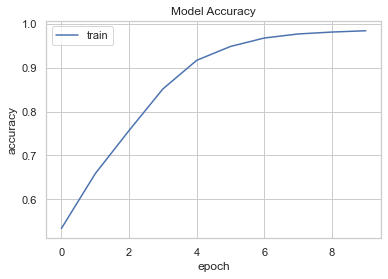

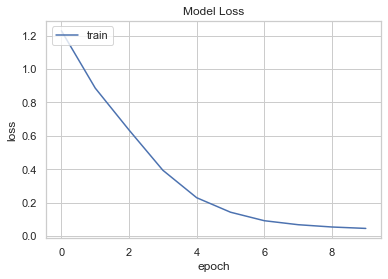

In [9]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [10]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [11]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [12]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()
# pred_df = df_drop(pred_df)

,Subject,Sequence,D|0,I|0+1,PF|0+1,RF|0+1,DT|0+1,D|1,I|1+2,PF|1+2,...,T4-RF-VAR.1,T4-G-VAR.1,T4-I-SD.1,T4-PF-SD.1,T4-RF-SD.1,T4-G-SD.1,T5_I|0+4.1,T5_PF|0+4.1,T5_RF|0+4.1,T5_G|0+4.1
0,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,9.412329e-03,0.006395,0.062381,0.045333,0.097017,0.079969,0.423147,0.582937,0.551112,0.710902
1,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,3.720000e-07,0.000002,0.006328,0.005632,0.000610,0.001306,0.335316,0.454740,0.408114,0.527538
2,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,3.322198e-01,0.288946,0.525115,0.486267,0.576385,0.537537,1.078749,1.151358,1.166748,1.239357
3,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,3.054200e-04,0.000046,0.034640,0.045301,0.017476,0.006815,0.352062,0.472674,0.439222,0.559834
4,adhy,quell,0.120807,-0.024914,0.095893,0.127188,0.247994,0.152102,-0.024045,0.128057,...,1.692164e-02,0.011546,0.107475,0.084844,0.130083,0.107452,0.296025,0.408024,0.384050,0.496050


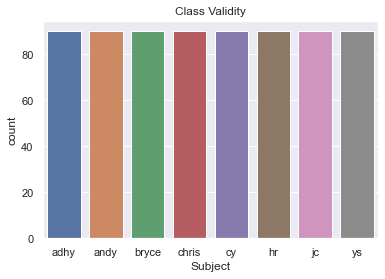

In [13]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [14]:
pred_dataset = pred_df.values
results = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

Y = CLASS_LIST
print(Y)
Y = np.asarray(Y)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

['adhy', 'andy', 'bryce', 'chris', 'cy', 'hr', 'jc', 'ys']


In [15]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

pred_results = np.column_stack((pred, acc))
pred_results = np.column_stack((results, pred_results))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=pred_results, index=None, columns=['Results', 'Prediction', 'Accuracy'])
# df = pd.DataFrame(data=pred_results, index=None, columns=['Prediction', 'Accuracy'])
print(df)

# =IF(EXACT(B2, C2), "Match", "Nope")

df.to_csv(RESULT_NAME)

    Results Prediction    Accuracy
0      adhy      bryce  0.99999976
1      adhy      bryce   0.9999994
2      adhy       adhy  0.99949086
3      adhy      bryce    0.931109
4      adhy      bryce   0.9985147
5      adhy       adhy   0.8208677
6      adhy      bryce  0.90018153
7      adhy      bryce  0.77612966
8      adhy         cy    0.941368
9      adhy      bryce  0.99993217
10     adhy      bryce  0.99999917
11     adhy       adhy  0.99789244
12     adhy      bryce  0.62063396
13     adhy      chris   0.5123575
14     adhy      bryce  0.68706524
15     adhy      bryce   0.9981834
16     adhy      chris   0.9996295
17     adhy         cy  0.99678934
18     adhy      bryce   0.9999181
19     adhy      bryce  0.99999976
20     adhy       adhy  0.99768543
21     adhy      bryce   0.9798462
22     adhy      bryce  0.99567336
23     adhy       adhy   0.7836345
24     adhy      bryce   0.9373546
25     adhy      bryce  0.88570905
26     adhy         cy   0.8999769
27     adhy       ad